In [8]:
import sys
sys.path.append("/home/kpintaric/LUMEN-Data-Science-IRMAS/")

import torch
import torch.nn as nn
from dataset import IRMASDataset
from utils import get_wav_files, CLASSES
from transforms import PreprocessPipeline, RandomCombine, LabelsFromTxt, OneHotEncode, ParentMultilabel
from torch.utils.data import Dataset
import torchaudio
import torchvision.transforms
import IPython.display as ipd

import matplotlib.pyplot as plt
import numpy as np

In [9]:
class PreprocessPipelineRNN(nn.Module):

    def __init__(self, target_sr):
        super().__init__()
        self.target_sr = target_sr

    def forward(self, signal, input_sr):
        signal = self._resample(signal, input_sr)
        signal = self._mix_down(signal)
        return signal
    
    def _mix_down(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _resample(self, signal, input_sr):
        if input_sr != self.target_sr:
            resampler = torchaudio.transforms.Resample(input_sr, self.target_sr)
            signal = resampler(signal)
        return signal
    

In [10]:
dir_path = "/home/kpintaric/LUMEN-Data-Science-IRMAS/data/Dataset/IRMAS_Training_Data"
files = get_wav_files(dir_path)

sample, sr = torchaudio.load(files[0])
ipd.Audio(sample, rate=sr)

In [30]:
target_sr = 16000
pipe = PreprocessPipelineRNN(target_sr=target_sr)
proc_sample = pipe(sample, sr)
ipd.Audio(proc_sample, rate=target_sr)

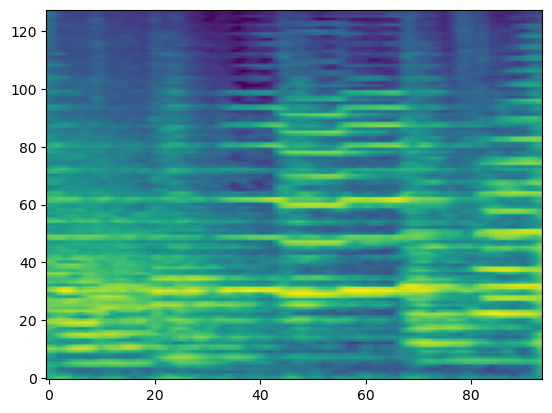

In [32]:
spec = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=2560, hop_length=512)(proc_sample)
spec_db = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)(spec)
plt.imshow(spec_db.squeeze(), aspect="auto", origin='lower');

In [40]:
from torch.nn.utils.rnn import pad_sequence

In [38]:
spec_db.mT.shape

torch.Size([1, 94, 128])

In [43]:
pad_sequence(spec_db.mT, batch_first=True).shape

torch.Size([1, 94, 128])

In [45]:
valid_dir_path = "/home/kpintaric/LUMEN-Data-Science-IRMAS/data/Dataset/IRMAS_Validation_Data"
valid_files = get_wav_files(valid_dir_path)

sample2, sr = torchaudio.load(valid_files[0])
ipd.Audio(sample2, rate=sr)

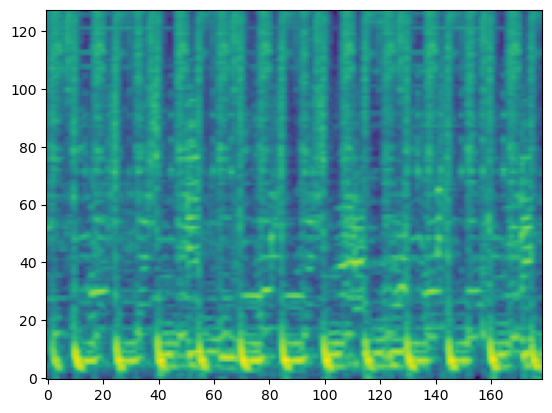

In [46]:
proc_sample2 = pipe(sample2, sr)
spec2 = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=2560, hop_length=512)(proc_sample2)
spec_db2 = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)(spec2)
plt.imshow(spec_db2.squeeze(), aspect="auto", origin='lower');

In [47]:
spec_db2.shape

torch.Size([1, 128, 179])

In [51]:
assert spec_db.mT.shape[-1] == spec_db2.mT.shape[-1]

In [76]:
seq_lens = sorted([spec_db.shape[-1], spec_db2.shape[-1]], reverse=True)
seq_lens

[179, 94]

In [70]:
padded_seq_batch = pad_sequence([spec_db.squeeze().T, spec_db2.squeeze().T], batch_first=True)
padded_seq_batch.shape

torch.Size([2, 179, 128])

In [71]:
from torch.nn.utils.rnn import pack_padded_sequence

In [90]:
packed_seq_batch = pack_padded_sequence(padded_seq_batch, lengths=seq_lens, batch_first=True)
packed_seq_batch

PackedSequence(data=tensor([[  1.9664,  -0.1660,  -2.2881,  ..., -20.4862, -19.4556, -21.1689],
        [  3.1191,   7.8724,   8.8767,  ...,  15.3958,  15.6294,  10.1813],
        [  5.8913,  -0.9715,  -5.2521,  ..., -22.9434, -22.6538, -24.4111],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]]), batch_sizes=tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 

In [89]:
lstm = nn.LSTM(input_size=128, hidden_size=3, batch_first=True)
output, (hn, cn) = lstm(packed_seq_batch.float())

In [97]:
lstm(spec_db.mT.float())

(tensor([[[ 3.1730e-07, -1.1874e-20, -3.2662e-04],
          [ 1.7285e-12, -3.0045e-23,  2.3708e-06],
          [ 3.3059e-18, -1.1915e-28,  1.2133e-08],
          [ 2.8718e-16, -8.1781e-32,  3.5636e-05],
          [ 1.2404e-16, -1.5387e-34,  1.1302e-04],
          [ 6.7115e-16, -4.6630e-32,  2.7662e-01],
          [-3.2593e-16, -5.5400e-31,  7.6735e-01],
          [-8.5132e-13, -6.6342e-31,  8.4539e-01],
          [ 2.2088e-08, -7.1162e-33,  1.4549e-01],
          [ 9.7783e-06, -3.8398e-33, -7.1595e-03],
          [ 1.4005e-03, -1.2081e-30, -4.1421e-07],
          [ 1.0820e-04, -2.6693e-27, -1.3609e-10],
          [ 1.1134e-11, -7.2067e-24, -2.0213e-08],
          [ 4.7788e-15, -3.4320e-23, -1.7084e-06],
          [ 7.5728e-11, -7.6492e-25, -2.2851e-09],
          [ 1.0135e-10, -2.8570e-25, -7.9356e-13],
          [ 8.8768e-12, -1.1757e-27, -6.2111e-15],
          [ 4.6251e-08, -1.1155e-28, -2.2356e-14],
          [ 1.0018e-04, -1.4458e-28, -7.6473e-13],
          [ 3.5229e-08, -1.4595